In [ ]:
# init repo notebook
!git clone https://github.com/rramosp/ppdl.git > /dev/null 2> /dev/null
!mv -n ppdl/content/init.py ppdl/content/local . 2> /dev/null
!pip install -r ppdl/content/requirements.txt > /dev/null

# Distribution objects 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.integrate import quad
from progressbar import progressbar as pbar
from rlxutils import subplots, copy_func

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

%matplotlib inline

2022-03-07 06:26:26.717202: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-07 06:26:26.717231: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


- you can sample (`distribution.sample`)
- you can compute probabilities (`distribution.log_prob`)
- they always work with **tensors**

In [3]:
d = tfd.Normal(loc=2, scale=3)
d

2022-03-07 06:26:28.678260: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-07 06:26:28.678308: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-07 06:26:28.678339: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (rlxyoga): /proc/driver/nvidia/version does not exist
2022-03-07 06:26:28.678764: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<tfp.distributions.Normal 'Normal' batch_shape=[] event_shape=[] dtype=float32>

In [4]:
s = d.sample(20)
s.shape

TensorShape([20])

In [5]:
s

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([ 0.84202063, -3.4651394 ,  0.24238634,  4.7199984 , -1.849772  ,
        0.75771403,  0.33977604, -0.0643971 ,  2.414379  ,  1.0733131 ,
        0.32795286, -1.4055476 ,  5.27031   ,  3.298139  ,  4.8651505 ,
        4.303988  ,  4.7135587 ,  5.32114   ,  1.4019012 ,  0.2740475 ],
      dtype=float32)>

In [6]:
d.log_prob(s)

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([-2.0920463, -3.6768703, -2.1891735, -2.4285727, -2.8409257,
       -2.1032884, -2.1706812, -2.254314 , -2.0270903, -2.0652592,
       -2.17287  , -2.6618707, -2.6117136, -2.1111712, -2.4736114,
       -2.31246  , -2.4266286, -2.630327 , -2.0374243, -2.183046 ],
      dtype=float32)>

for a larger sample

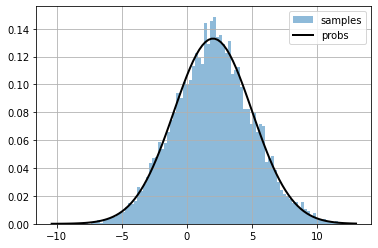

In [7]:
s = d.sample(10000).numpy()
xr = np.linspace(np.min(s), np.max(s), 100)
xr_probs = np.exp(d.log_prob(xr))

plt.hist(s, bins=100, alpha=.5, density=True, label="samples");
plt.plot(xr, xr_probs, color="black", lw=2, label="probs")
plt.grid();
plt.legend();

## Batches of distributions

You can simultaneously define many distributions of the same type with the shape of the parameters.

This is a **batch of distributions**.

All distributions in a batch are of the **same type** but may have **different parameter values**.

In [8]:
d = tfd.Normal(loc=[2,8], scale=[4,10])
s = d.sample(10000).numpy()
s.shape

(10000, 2)

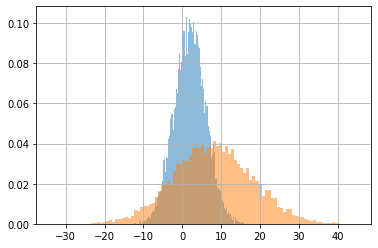

In [9]:
for i in range(s.shape[1]):
    plt.hist(s[:,i], alpha=.5, bins=100, density=True)
plt.grid();

The distribution configuration is stored in the distirbution object itself:

- the `batch_shape`
- the `parameters`

In [19]:
d.batch_shape

TensorShape([2])

In [20]:
d.parameters

{'loc': [2, 8],
 'scale': [4, 10],
 'validate_args': False,
 'allow_nan_stats': True,
 'name': 'Normal'}

### as complex as you want

In [21]:
means = np.random.randint(10, size=(2,3,4))*1. + 5
stds = np.random.randint(5, size=means.shape)*1. + 1

print(f"means\n{means}")
print(f"stds\n{stds}")

d = tfd.Normal(loc=means, scale=stds)
s = d.sample(10000).numpy()

print ("\nsample shape", s.shape)

print (f"\nthere are {np.product(s.shape[1:])} batch distributions")

means
[[[12. 13. 14. 10.]
  [11. 11. 12.  5.]
  [11.  5.  5.  5.]]

 [[ 8. 13. 14.  7.]
  [ 7. 11. 12. 10.]
  [13.  7.  5.  9.]]]
stds
[[[3. 5. 2. 5.]
  [5. 5. 3. 3.]
  [5. 4. 5. 2.]]

 [[4. 2. 4. 2.]
  [4. 1. 3. 5.]
  [4. 4. 3. 3.]]]

sample shape (10000, 2, 3, 4)

there are 24 batch distributions


In [22]:
d.batch_shape

TensorShape([2, 3, 4])

observe the samples on each batch distribution

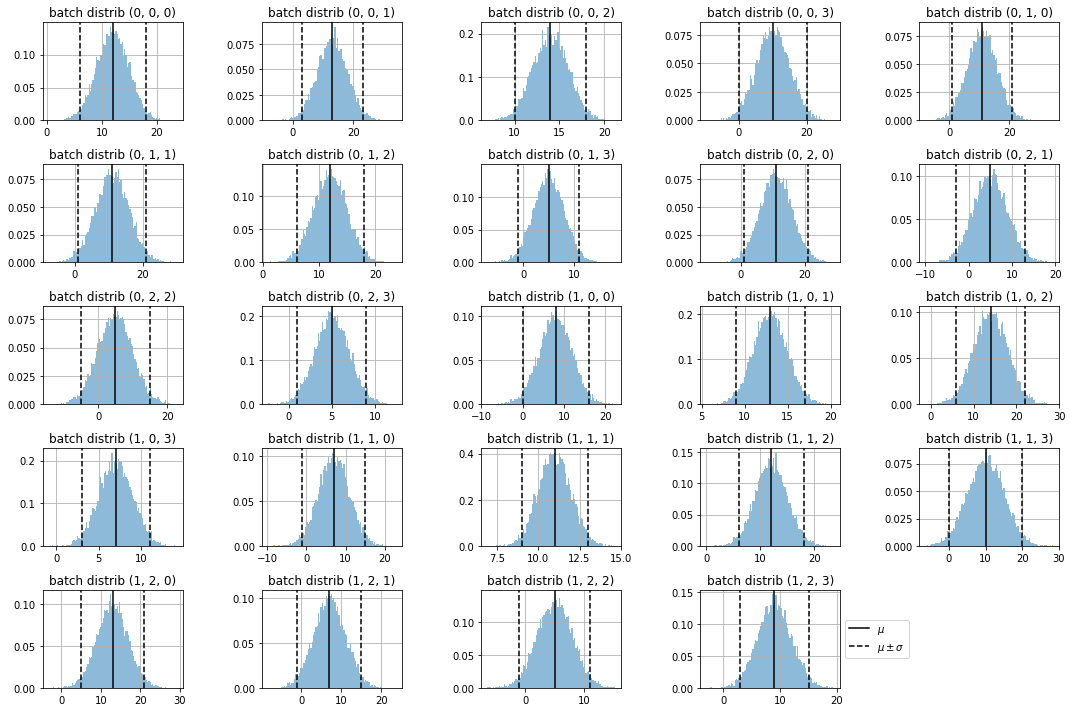

In [25]:
import itertools
dims = list(itertools.product(*[range(i) for i in d.batch_shape]))
for ax, dim in subplots(dims, n_cols=5, usizey=2):
    sdim = s[(..., *dim)]
    plt.hist(sdim, bins=100, density=True, alpha=.5)
    plt.axvline(means[dim], color="black", label="$\mu$")
    plt.axvline(means[dim] + 2*stds[dim], color="black", label="$\mu \pm\sigma$", ls="--")
    plt.axvline(means[dim] - 2*stds[dim], color="black", ls="--")
    plt.title(f"batch distrib {dim}")
    plt.grid();
    if dim==dims[-1]:
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()

## Broadcasting parameters for distribution batches

broadcasting works between different parameters of the distributions

In [26]:
# a batch of two normals with the same std
d = tfd.Normal(loc=[2,5], scale=2)
s = d.sample(10000).numpy()
s.shape

(10000, 2)

In [27]:
d.batch_shape

TensorShape([2])

In [28]:
d.parameters

{'loc': [2, 5],
 'scale': 2,
 'validate_args': False,
 'allow_nan_stats': True,
 'name': 'Normal'}

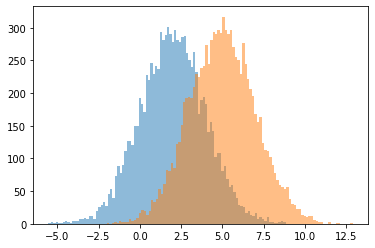

In [29]:
for i in range(s.shape[1]):
    plt.hist(s[:,i], bins=100, alpha=.5)

In [30]:
# a batch of two normals with the same std
means = np.r_[[[2.,5.], [8.,10.]]]
stds  = np.r_[[[1.,2.]]]

print(f"means\n{means}")
print(f"stds\n{stds}")

d = tfd.Normal(loc=means, scale=stds)
s = d.sample(10000).numpy()
s.shape

means
[[ 2.  5.]
 [ 8. 10.]]
stds
[[1. 2.]]


(10000, 2, 2)

In [31]:
d.batch_shape

TensorShape([2, 2])

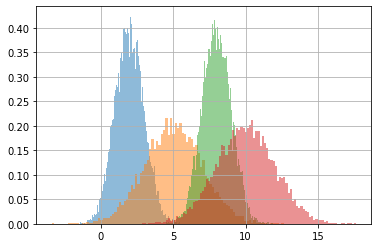

In [32]:
dims = list(itertools.product(*[range(i) for i in s.shape[1:]]))
for dim in dims:
    plt.hist(s[(...,*dim)], density=True, alpha=.5, bins=100)
plt.grid();

observe **carefully** that broadcasting is done across the dimension that matches

In [33]:
# a batch of two normals with the same std
print(f"means\n{means}")
print(f"stds\n{stds.T}")

d = tfd.Normal(loc=means, scale=stds.T)
s = d.sample(10000).numpy()
s.shape

means
[[ 2.  5.]
 [ 8. 10.]]
stds
[[1.]
 [2.]]


(10000, 2, 2)

In [34]:
d.batch_shape

TensorShape([2, 2])

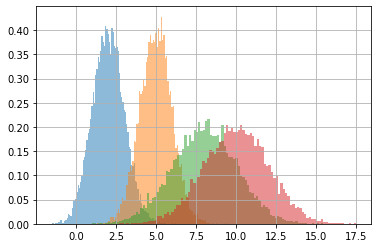

In [35]:
dims = list(itertools.product(*[range(i) for i in s.shape[1:]]))
for dim in dims:
    plt.hist(s[(...,*dim)], density=True, alpha=.5, bins=100)
plt.grid();

## `tfp` distribution objects accept differentiable (_learnable_) parameters

so that we can use TF variables for their parameters and then optimize

for instance, let's fit a normal distribution to some data by maximizing the log likelihood.

assuming:

$$x \sim \mathcal{N}(z_\mu, z_\sigma)$$

we want:

$$\underset{z_\mu, z_\sigma}{\text{arg max}} \;\; \frac{1}{N} \sum_i \log P_{\mathcal{N}(z_\mu, z_\sigma)}(x_i) $$


2022-03-06 05:04:36.589174: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-06 05:04:36.589232: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-06 05:04:36.589273: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (rlxyoga): /proc/driver/nvidia/version does not exist
2022-03-06 05:04:36.590383: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


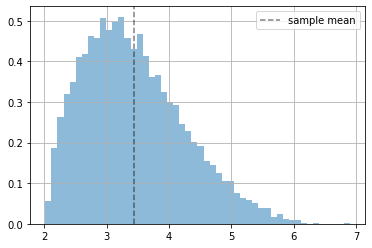

In [3]:
# we have some data (which actually is not generated by a Normal distribution)

x = 5*tfd.Beta(2.,5).sample(10000)+2
plt.hist(x.numpy(), bins=50, density=True, alpha=.5);
plt.axvline(np.mean(x), ls="--", color="black", alpha=.5, label="sample mean")
plt.grid(); plt.legend();

## fitting a `Normal` distribution by _hand_

since the data actually comes from a different distribution the fitting is not so good, we are using a wrong assumption.

recall that the `GradientTape` must **watch** how the expresion you want to optimize is built, and therefore we **must** create the distribution object within the `GradientTape`

In [4]:
zm = tf.Variable(0, dtype=tf.float32)
zs = tf.Variable(1, dtype=tf.float32)

In [5]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

for epoch in range(100):
    
    with tf.GradientTape() as tape:
        distribution = tfd.Normal(loc=zm, scale=tf.math.softplus(zs))        
        negloglik    = -tf.reduce_mean(distribution.log_prob(x))
        
    gradients = tape.gradient(negloglik, [zm, zs])
    
    optimizer.apply_gradients(zip(gradients,[zm, zs]))
    
[zm, zs]

[<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=3.4183526>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0727701>]

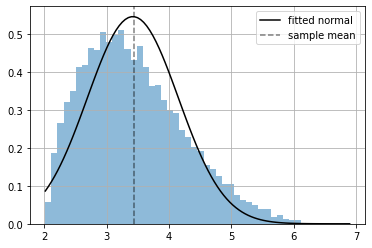

In [6]:
xr = np.linspace(np.min(x), np.max(x), 100)
plt.hist(x.numpy(), bins=50, density=True, alpha=.5);
plt.plot(xr, np.exp(distribution.log_prob(xr).numpy()), color="black", label="fitted normal");
plt.axvline(np.mean(x), ls="--", color="black", alpha=.5, label="sample mean")
plt.grid(); plt.legend();

observe what would happen if we create the distribution object **outside** the gradient tape

In [7]:
zm = tf.Variable(0, dtype=tf.float32)
zs = tf.Variable(1, dtype=tf.float32)

distribution = tfd.Normal(loc=zm, scale=tf.math.softplus(zs))        

optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

with tf.GradientTape() as tape:
    loglik = -tf.reduce_mean(distribution.log_prob(x))

gradients = tape.gradient(loglik, [zm, zs])

optimizer.apply_gradients(zip(gradients,[zm, zs]))

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1>